### Step 1: Import Data with CoinPaprika API (https://api.coinpaprika.com/)

In [1]:
import Coinpaprika
import pandas as pd                        
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

In [2]:
api_client = Coinpaprika.Client()
market_overview = api_client.global_market_overview()

#print(market_overview)

all_coins = api_client.coins()
for i  in range(0, 10):
    print(all_coins[i]['id'])

btc-bitcoin
eth-ethereum
bnb-binance-coin
ada-cardano
xrp-xrp
doge-dogecoin
usdt-tether
dot-polkadot
bch-bitcoin-cash
ltc-litecoin


## get historical data 

In [3]:
from datetime import datetime, timedelta

coin = 'btc-bitcoin'
color = 'green'

hist = api_client.coins.historical_OHLC(
    coin_id=coin,
    start=datetime.now() - timedelta(weeks=52) - timedelta(days=0),
    end=datetime.now() - timedelta(days=0)
)
# TODO: "clean up" data (na's, outliers, etc.)

In [4]:
alldata = []

for i in range(1,len(hist)):
    alldata.append({
        "close": hist[i]['close'],
        #"open": hist[i-1]['open'],
        #"volume": hist[i-1]['volume'],
        #"variance": (hist[i-1]['high'] - hist[i-1]['low'])
    })

In [5]:
print(alldata[0])
print(len(alldata))

{'close': 9744.90778298}
364


### New Model with Keras


In [6]:
alldataFrame = pd.DataFrame(alldata)

In [7]:
scaler = MinMaxScaler()

print(alldataFrame.shape)

scaled_close = scaler.fit_transform(alldataFrame.values)#.reshape(-1, 1))

print(scaled_close.shape)

SEQ_LEN = 100

(364, 1)
(364, 1)


In [8]:
def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

In [9]:
def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

In [10]:
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.85)
print(X_train.shape)
print(X_test.shape)

(224, 99, 1)
(40, 99, 1)


In [11]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1
BATCH_SIZE = 64

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True), input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
model.add(Dense(units=1))
model.add(Activation('linear'))

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/20
4/4 [==============================] - 10s 1s/step - loss: 0.0118 - val_loss: 0.0026
Epoch 2/20
4/4 [==============================] - 2s 362ms/step - loss: 0.0323 - val_loss: 0.1880
Epoch 3/20
4/4 [==============================] - 2s 360ms/step - loss: 0.0131 - val_loss: 0.0061
Epoch 4/20
4/4 [==============================] - 1s 358ms/step - loss: 0.0213 - val_loss: 0.0180
Epoch 5/20
4/4 [==============================] - 2s 358ms/step - loss: 0.0113 - val_loss: 0.0212
Epoch 6/20
4/4 [==============================] - 2s 382ms/step - loss: 0.0050 - val_loss: 0.0067
Epoch 7/20
4/4 [==============================] - 2s 367ms/step - loss: 0.0019 - val_loss: 0.0150
Epoch 8/20
4/4 [==============================] - 2s 364ms/step - loss: 0.0043 - val_loss: 0.0136
Epoch 9/20
4/4 [==============================] - 2s 367ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 10/20
4/4 [==============================] - 1s 354ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 11/20
4/4 [====

In [12]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 38ms/step - loss: 0.0224


0.022434936836361885

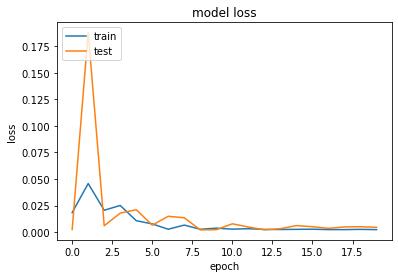

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

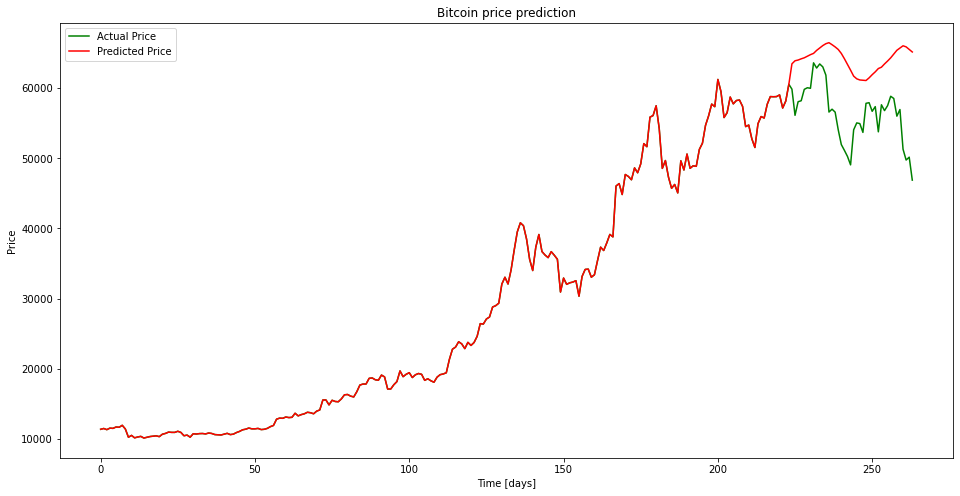

In [14]:
y_hat = model.predict(X_test)

#frame = pd.DataFrame(y_test)


y_train_inverse = scaler.inverse_transform(y_train)
y_test_inverse = scaler.inverse_transform(y_test)
#y_hat_inverse = scaler.inverse_transform(y_hat)


y_testclose = []
for i in range(0, len(y_test_inverse)):
    y_testclose.append(y_test_inverse[i][0])
    
scale = y_test_inverse[0][0] / y_test[0][0]
y_predictclose = []
for i in range(0, len(y_hat)):
    y_predictclose.append(y_hat[i] * scale)
 

#alldata
y_actual_complete = []
y_predict_complete = []
for i in range(0, (len(y_train_inverse) + len(y_test_inverse))):
    if i < len(y_train_inverse):
        y_actual_complete.append(y_train_inverse[i])
        y_predict_complete.append(y_train_inverse[i])
    else:
        y_actual_complete.append(y_test_inverse[(i - len(y_train_inverse))])
        y_predict_complete.append(y_predictclose[(i - len(y_train_inverse))])


plt.figure(figsize=(16,8))
plt.plot(y_actual_complete, label="Actual Price", color='green')
#plt.plot(y_testclose, label="Actual Price", color='green')
plt.plot(y_predict_complete, label="Predicted Price", color='red')
    
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();